# **Get Data and Libraries**

In [31]:
! wget https://raw.githubusercontent.com/gevabriel/dataset/main/indo_spam.csv

--2024-07-26 03:01:33--  https://raw.githubusercontent.com/gevabriel/dataset/main/indo_spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132904 (130K) [text/plain]
Saving to: ‘indo_spam.csv.1’

indo_spam.csv.1     100%[===================>] 129.79K  --.-KB/s    in 0.03s   

2024-07-26 03:01:33 (4.90 MB/s) - ‘indo_spam.csv.1’ saved [132904/132904]



In [1]:
! pip install -U accelerate

In [2]:
! pip install -U transformers

In [3]:
! pip install datasets

# **Import Data**

In [4]:
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
!pip install pysastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import load_metric

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Load Data**

In [5]:
df = pd.read_csv('indo_spam.csv')
df

,Kategori,Pesan
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(
2,ham,Kalau mau bikin model/controller mending per a...
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...
...,...,...
1138,ham,Yg ragu sm bulet/datar atau yg pgn ikutan deba...
1139,ham,"Semangat yang ibu gita, ibu putri dan bapak ad..."
1140,ham,"nama1, minta database kamu sama view dan contr..."
1141,spam,Dapatkan GRATIS 1 cappuccino (hot/ice) & Freza...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  1143 non-null   object
 1   Pesan     1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


## **Data Cleaning**

In [7]:
df['Kategori'].value_counts()

Kategori
spam    574
ham     569
Name: count, dtype: int64

In [8]:
df.isnull().sum()

Kategori    0
Pesan       0
dtype: int64

In [9]:
duplicates = df[df.duplicated(keep=False)]
print("Duplicate Rows:\n", duplicates)

Duplicate Rows:
     Kategori                                              Pesan
444      ham  bebas nama1, terus nanti kalau ada tgl libur, ...
833      ham  bebas nama1, terus nanti kalau ada tgl libur, ...


In [10]:
df_cleaned = df.drop_duplicates()

# Display the number of duplicates removed
print(f"Number of duplicates removed: {df.duplicated().sum()}")
print("Cleaned DataFrame:\n", df_cleaned.head())

Number of duplicates removed: 1
Cleaned DataFrame:
   Kategori                                              Pesan
0     spam  Plg Yth: Simcard anda mendptkan bonus poin plu...
1      ham    Iya ih ko sedih sih gtau kapan lg ke bandung :(
2      ham  Kalau mau bikin model/controller mending per a...
3      ham  Selamat nama1. Semoga selalu menempuh hidup ya...
4     spam  Tingkatkan nilai isi ulang Anda selanjutnya mi...


In [11]:
df.shape

(1143, 2)

# **Data Text Processing**

In [12]:
df2 = df.copy()

In [13]:
df2['label'] = df2['Kategori'].replace({ 'spam':0,  'ham':1 })
df2

,Kategori,Pesan,label
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...,0
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(,1
2,ham,Kalau mau bikin model/controller mending per a...,1
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...,1
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...,0
...,...,...,...
1138,ham,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,1
1139,ham,"Semangat yang ibu gita, ibu putri dan bapak ad...",1
1140,ham,"nama1, minta database kamu sama view dan contr...",1
1141,spam,Dapatkan GRATIS 1 cappuccino (hot/ice) & Freza...,0


In [14]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('indonesian')))
stpwds_id.append('oh') # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

In [15]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [16]:
df

,Kategori,Pesan
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(
2,ham,Kalau mau bikin model/controller mending per a...
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...
...,...,...
1138,ham,Yg ragu sm bulet/datar atau yg pgn ikutan deba...
1139,ham,"Semangat yang ibu gita, ibu putri dan bapak ad..."
1140,ham,"nama1, minta database kamu sama view dan contr..."
1141,spam,Dapatkan GRATIS 1 cappuccino (hot/ice) & Freza...


In [17]:
df['Pesan_processed'] = df['Pesan'].apply(lambda x: text_preprocessing(x))
df

,Kategori,Pesan,Pesan_processed
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...,plg yth simcard mendptkan bonus poin plus plus...
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(,iya ih ko sedih sih gtau lg bandung
2,ham,Kalau mau bikin model/controller mending per a...,bikin model controller mending y
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...,selamat nama moga tempuh hidup bahagia senang
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...,tingkat nilai isi ulang minimal rp ribu paket ...
...,...,...,...
1138,ham,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,yg ragu sm bulet datar yg pgn ikut debat kusir v
1139,ham,"Semangat yang ibu gita, ibu putri dan bapak ad...",semangat gita putri adison esok moga baik aamiin
1140,ham,"nama1, minta database kamu sama view dan contr...",nama database view controller js dropdown kota
1141,spam,Dapatkan GRATIS 1 cappuccino (hot/ice) & Freza...,dapat gratis cappuccino hot ice freza transaks...


# **Exploratory Data Analysis**

In [18]:
df2 = df2.rename(columns={'Pesan_processed': 'Pesan_processed', 'label':'label'})
df2['label'] = df2['label'].map({0: 0.0, 1: 1.0})
# # Output first five rows
df2.head()

,Kategori,Pesan,label
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...,0.0
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(,1.0
2,ham,Kalau mau bikin model/controller mending per a...,1.0
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...,1.0
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...,0.0


<Axes: xlabel='label'>

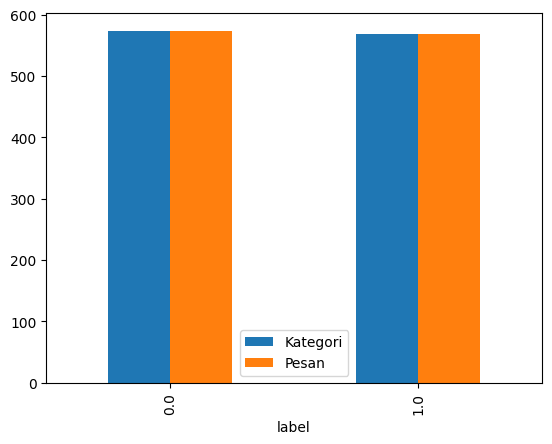

In [19]:
df2.groupby('label').count().plot(kind='bar')

Text(0.5, 0.98, 'Distribution of text length for Spam Kategori Message.')

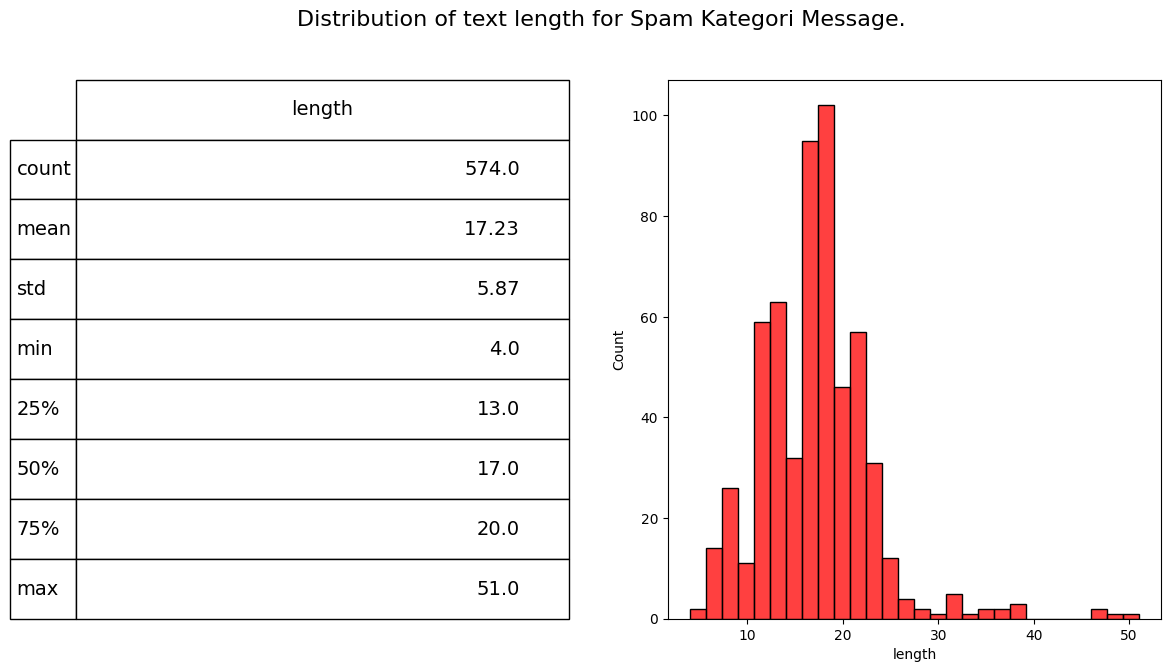

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(14,7))
df2['length'] = df.Pesan_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df2[df2['Kategori']=='spam']['length'], ax=ax1,color='red')
describe = df2.length[df2.Kategori=='spam'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Spam Kategori Message.', fontsize=16)

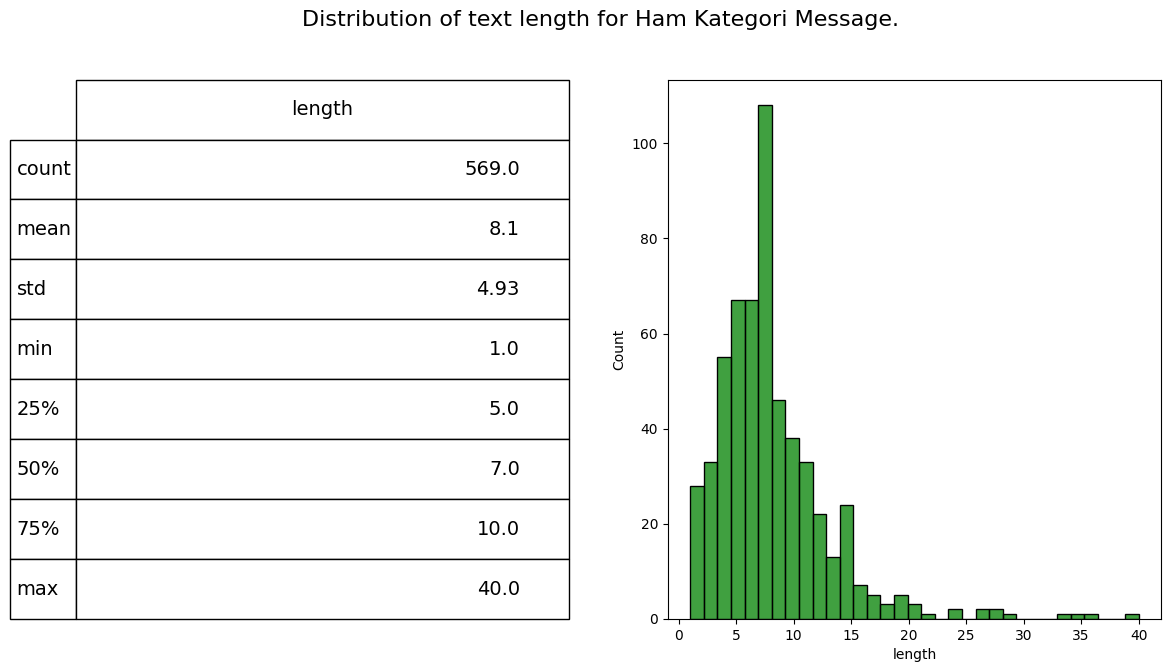

In [21]:
fig = plt.figure(figsize=(14,7))
df2['length'] = df.Pesan_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df2[df2['Kategori']=='ham']['length'], ax=ax1,color='green')
describe = df2.length[df2.Kategori=='ham'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Ham Kategori Message.', fontsize=16)

plt.show()

# **Feature Engineering**

In [23]:
df['label'] = df['Kategori'].apply(lambda x:0 if x=="ham" else 1)

In [26]:
df

,Kategori,Pesan,Pesan_processed,label
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...,plg yth simcard mendptkan bonus poin plus plus...,1
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(,iya ih ko sedih sih gtau lg bandung,0
2,ham,Kalau mau bikin model/controller mending per a...,bikin model controller mending y,0
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...,selamat nama moga tempuh hidup bahagia senang,0
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...,tingkat nilai isi ulang minimal rp ribu paket ...,1
...,...,...,...,...
1138,ham,Yg ragu sm bulet/datar atau yg pgn ikutan deba...,yg ragu sm bulet datar yg pgn ikut debat kusir v,0
1139,ham,"Semangat yang ibu gita, ibu putri dan bapak ad...",semangat gita putri adison esok moga baik aamiin,0
1140,ham,"nama1, minta database kamu sama view dan contr...",nama database view controller js dropdown kota,0
1141,spam,Dapatkan GRATIS 1 cappuccino (hot/ice) & Freza...,dapat gratis cappuccino hot ice freza transaks...,1


In [27]:
df = df.drop(columns=['Kategori','Pesan'])
df.rename(columns={"Pesan_processed": "Teks"}, inplace=True)
df

,Teks,label
0,plg yth simcard mendptkan bonus poin plus plus...,1
1,iya ih ko sedih sih gtau lg bandung,0
2,bikin model controller mending y,0
3,selamat nama moga tempuh hidup bahagia senang,0
4,tingkat nilai isi ulang minimal rp ribu paket ...,1
...,...,...
1138,yg ragu sm bulet datar yg pgn ikut debat kusir v,0
1139,semangat gita putri adison esok moga baik aamiin,0
1140,nama database view controller js dropdown kota,0
1141,dapat gratis cappuccino hot ice freza transaks...,1


# **Data Splitting**

In [28]:
RANDOM_SEED = 42

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.4,
    random_state=RANDOM_SEED,
)

In [29]:
print(f'Total Train: {len(df_train)}')
print(f'Total Val  : {len(df_val)}')
print(f'Total Test : {len(df_test)}')

Total Train: 914
Total Val  : 137
Total Test : 92


In [30]:
df_train.to_csv("train.csv", index=False)
df_val.to_csv("eval.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [31]:
from datasets import load_dataset

files = {
    "train": "train.csv",
    "eval": "eval.csv",
    "test": "test.csv",
}

dataset = load_dataset('csv', data_files=files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# **IndoBERT Models**

In [32]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [33]:
def tokenize_function(text):
    return tokenizer(text["Teks"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/914 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

In [34]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

In [35]:
import torch
torch.cuda.empty_cache()

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [36]:
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
from transformers import TrainingArguments
from torch import clamp

training_args = TrainingArguments(
    "test_trainer",
    per_device_train_batch_size=4,
)

In [38]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

training_history = trainer.train()


<ipython-input-38-fd3739473b36>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Step,Training Loss
500,0.189100


In [40]:
import numpy as np

In [41]:
evaluation_history = trainer.evaluate()
evaluation_history

{'eval_loss': 0.0724029466509819,
 'eval_accuracy': 0.9854014598540146,
 'eval_runtime': 2.0317,
 'eval_samples_per_second': 67.432,
 'eval_steps_per_second': 8.86,
 'epoch': 3.0}

In [42]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [43]:
actual_label = df_test['label']

In [44]:
print(classification_report(prediction, actual_label, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.98      0.98      0.98        48

    accuracy                           0.98        92
   macro avg       0.98      0.98      0.98        92
weighted avg       0.98      0.98      0.98        92



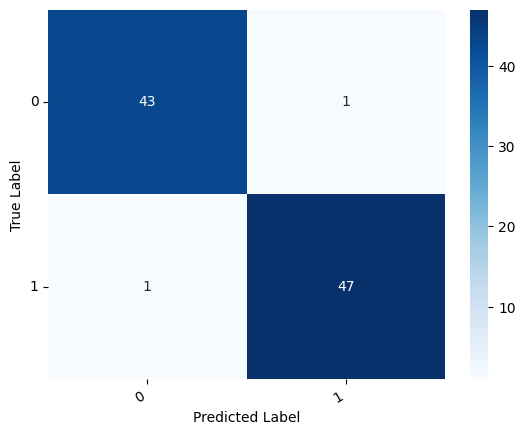

In [45]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [46]:
model.save_pretrained("model")

In [47]:
model = AutoModelForSequenceClassification.from_pretrained("model")

In [48]:
trainer = Trainer(model=model)

In [49]:
def predict(text):
    tokenized = tokenizer(text, padding='max_length', max_length=256)
    label = trainer.predict([tokenized]).predictions.argmax(1)[0]
    if label == 0:
        print(f'Predicted: Ham [{label}]')
    else:
        print(f'Predicted: Spam [{label}]')

In [50]:
predict("""
Apapun profesimu, pasti ada risiko kerjanya. Ayo segera daftar jadi peserta BPJS Ketenagakerjaan biar bisa #KerjaKerasBebasCemas. www.bpjsketenagakerjaan.go.id
""")

Predicted: Spam [1]


In [51]:
predict("""
    Assalamualaikum Pak. Ini dg nama1 ilkom 2012. Maaf Pak td saya ninggalin proposal di meja Bapak di atas printer. Terima kasih Pak.
""")

Predicted: Ham [0]
